## Modelling Customers Lifetime Value For Non-Contractual Business 
focus in revenue known as equity model

Just to summarise: knowing the lifetime value of your customers helps you:

    -Segment your customers and develop and deliver unique segment-
     specific marketing Treatments.
    -Define your return on Investment.
    -Forecast customer satisfaction.
    -Innovate and optimize marketing tools, tactics and channels.
    -Adjust communication campaigns and messages.
    -Conduct profitable loyalty programs.
    -Cross-sell and up-sell based on individual patterns of buying.
    
Three stochastic models are the most popular ones for calculating CLV namely

    -BG/NBD, 
    -BG/BB, 
    -Pareto/NBD.
    (linked to excel explaination)
    https://www.internetrix.com.au/blog/how-to-model-customer-lifetime-value/

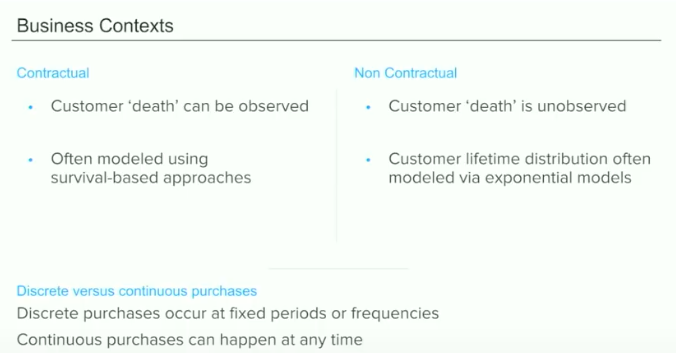

In [12]:
from IPython.display import Image
Image(filename='customerlifetimevaluetwo.png')

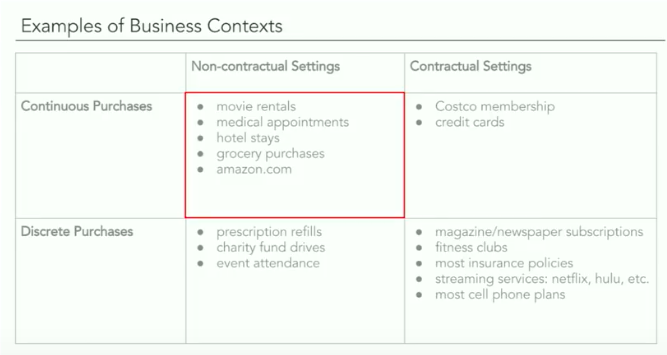

In [13]:
Image(filename='customerlifetimevalue.png')

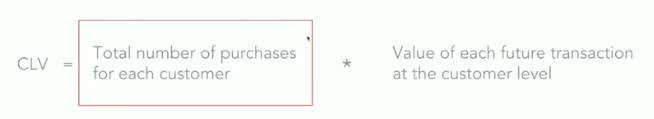

In [14]:
Image(filename='clvmodel.png')


In [49]:
# plotting modules
#import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats/Regresions Packages
from sklearn import linear_model
from sklearn.metrics import r2_score

# make sure charts appear in the notebook:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
#import pandas_profiling
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder

import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge
from sklearn import metrics
from sklearn.model_selection import train_test_split
import scipy.stats
from sklearn.linear_model import SGDRegressor, SGDClassifier,LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,BaggingRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
#from xgboost import XGBClassifier

sns.set_style('whitegrid')

%matplotlib inline
import numpy as np
import pandas as pd
#import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error
#https://www.kaggle.com/ksjpswaroop/yelp-data-analysis
#https://www.kaggle.com/ksjpswaroop/yelp-data-analysis
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD
#import graphlab
#import turicreate
#from surprise import SVD
#from surprise import Dataset
#from surprise.model_selection import cross_validate
#import Recommenders as Recommenders
import lifetimes

## Lifetimes can be used to understand and predict future usage based on a few lax assumption:

Entities under study may die after some random period of time.
Entities interact with you when they are alive.
Lifetimes can be used to both estimate if these entities are still alive, and predict how much more they will interact based on their existing history. If this is too abstract, consider these situations:

Predicting how often a visitor will return to your website.
Understanding how frequently a patient may return to a hospital.
Predicting individuals who gave "died" using only their usage history.
Really, "customers" is a very general term here, (similar to "birth" and "death" in survival analysis). Whenever we have individuals repeating occurrences, we can use Lifetimes to help understand behaviour.

## 1 Load Data

In [74]:
from lifetimes.datasets import load_dataset

import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [75]:
#cleaning
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date

#minimum 1 quanity of purchace
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']

#column use
CLV_colums = ['CustomerID', 'InvoiceDate', 'Sales']
clean_column = df[CLV_colums]
print(clean_column.head())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34


In [77]:
print (clean_column['InvoiceDate'].min())
print (clean_column['InvoiceDate'].max())

2010-12-01
2011-12-09


## 2 RFM
RFM has been used in marketing to predict customer behaviour for more than 50 years and is widely known as one of the most powerful techniques in marketing

One of the advantages of the Pareto/NBD and similar lifetime value models is the small amount of required data to generate an effective result. From a transaction log like above, it is easy to generate a recency-frequency matrix used by the Pareto/NBD model.

    -frequency: number of repeat purchases
    -recency: time of most recent purchase
    -T: total elapsed time since customer's first purchase

In [79]:
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes.estimation import *
data = summary_data_from_transaction_data(clean_column, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
print('Monetary value is value in currency of a person.')
data.head()

Monetary value is value in currency of a person.


,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


In [91]:
print('customer purchase' ,sum(data['frequency'] == 0)/float(len(data)))
print(data['frequency'].describe())

customer purchase 0.3569946992394561
count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64


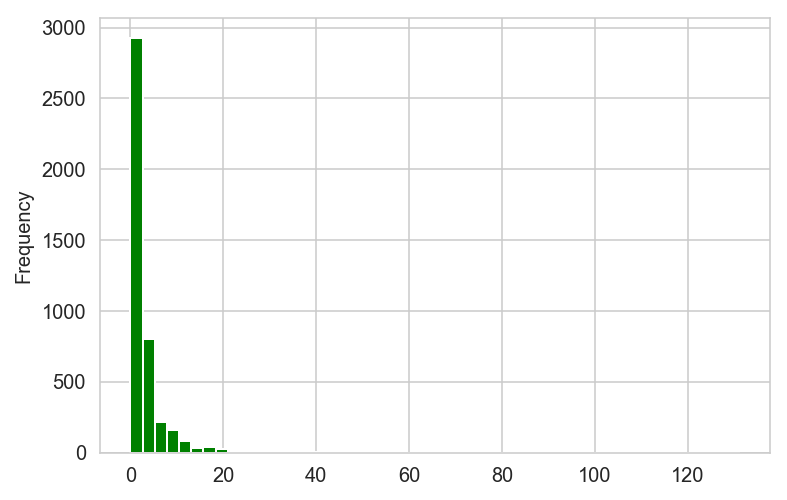

In [93]:
data['frequency'].plot(kind='hist', bins=50, color= 'g')

## 3 Visualizing our Frequency/Recency Matrix

In [95]:
from lifetimes import BetaGeoFitter
#We'll use the BG/NBD model first
# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.93, b: 2.21, r: 0.83>


After fitting, we have lots of nice methods and properties attached to the fitter object.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

a customer bought from you every day for three weeks straight, and we haven't heard from them in months. What are the chances they are still "alive"? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. 

#### We can visualize this relationship using the Frequency/Recency matrix 
computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

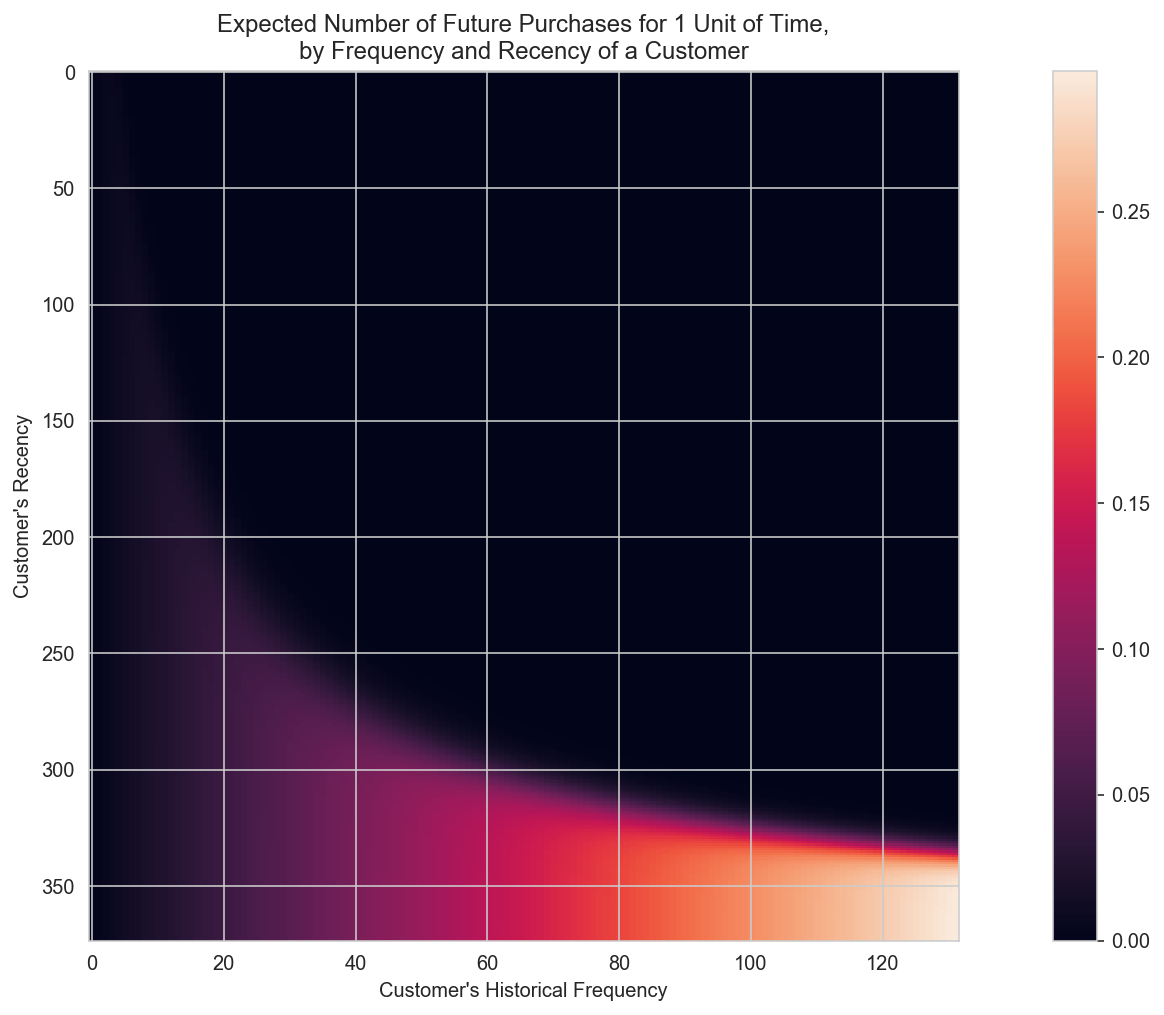

In [96]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(17,8))
plot_frequency_recency_matrix(bgf)

If a customer has made 120 purchases, and his latest purchase was when he was approximately 350 days old (i.e. Recency: the duration between her first transaction and her latest transaction is 350 days), then he is our best customer (bottom-right).

Customers who have purchased a lot and purchased recently will likely be the best customers in the future. We will never have enough of them.
Customers who have purchased a lot but not recently (top-right corner), have probably gone.

There are also another type of customers that around (40, 300) that represents the customer who buys infrequently, and we have not seen him recently, so he might buy again. However, we are not sure if he has gone or just between purchases.

#### We can predict which customers are surely alive:

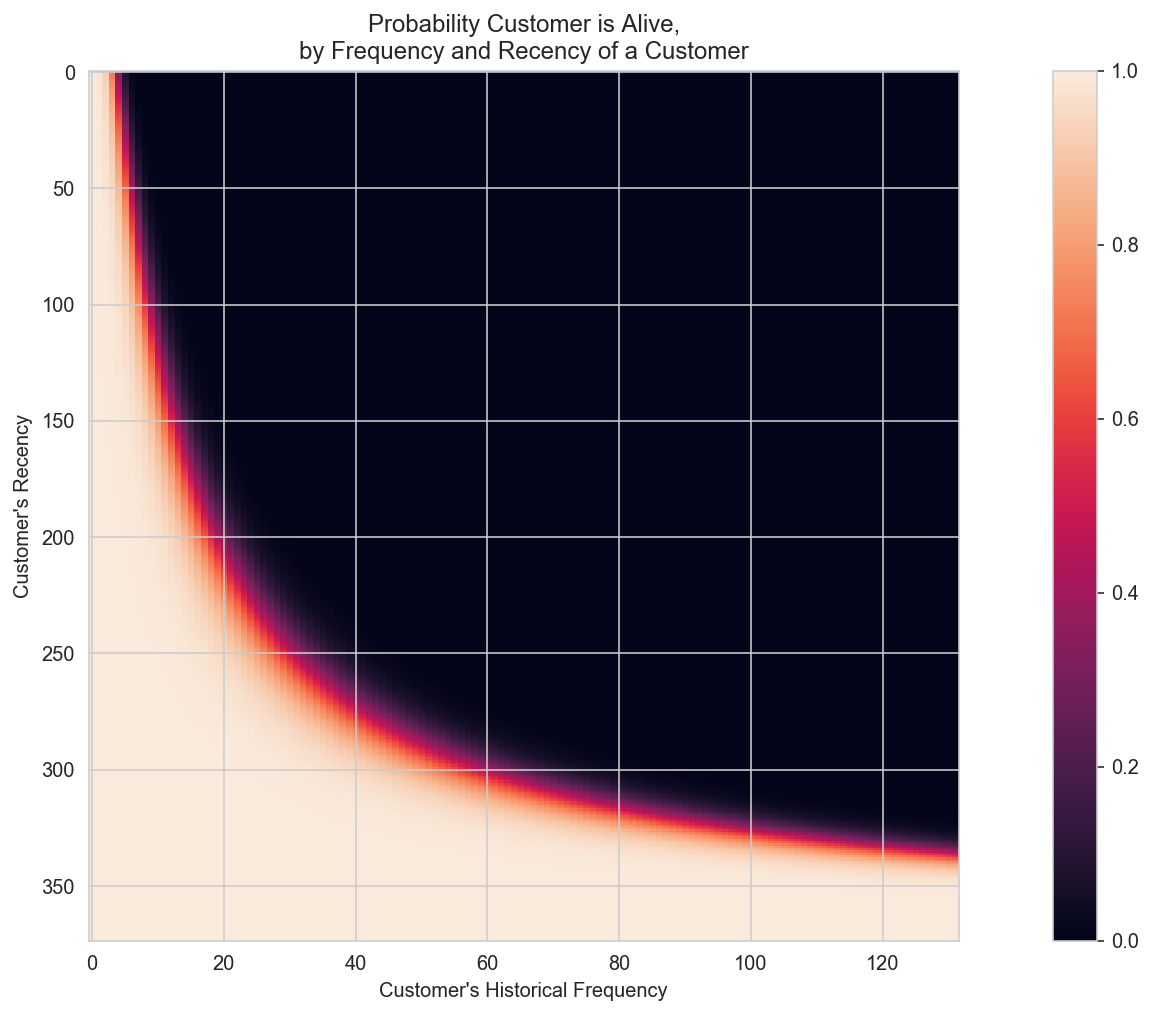

In [98]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(17,8))
plot_probability_alive_matrix(bgf)

Customers who have purchased recently are almost surely “alive”.

Customers who have purchased a lot but not recently, are likely to have dropped out. And the more they bought in the past, the more likely they have dropped out. They are represented in the upper-right.

We are ranking customers from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

----

## 4 Ranking customers from best to worst

Let's return to our customers and rank them from "highest expected purchases in the next period" to lowest. Models expose a method that will predict a customer's expected purchases in the next period using their history.

In [103]:
t = 10
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(8)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14527.0,53.0,367.0,369.0,155.016415,1.229055
13089.0,65.0,367.0,369.0,893.714308,1.503064
12971.0,70.0,369.0,372.0,159.211286,1.606224
14606.0,88.0,372.0,373.0,135.890114,2.009898
15311.0,89.0,373.0,373.0,677.729438,2.032533
17841.0,111.0,372.0,373.0,364.452162,2.530331
12748.0,113.0,373.0,373.0,298.360885,2.575595
14911.0,131.0,372.0,373.0,1093.661679,2.982881


 top 5 customers that the model expects them to make purchases in the next 8 day.

## 5 Assessing model fit

I can predict and we can visualize our customers' behaviour, but is our model correct? There are a few ways to assess the model's correctness. The first is to compare your data versus artificial data simulated with your fitted model's parameters.

We can see that our actual data and our simulated data line up well. This proves that our model doesnt suck.


<Figure size 1224x576 with 0 Axes>

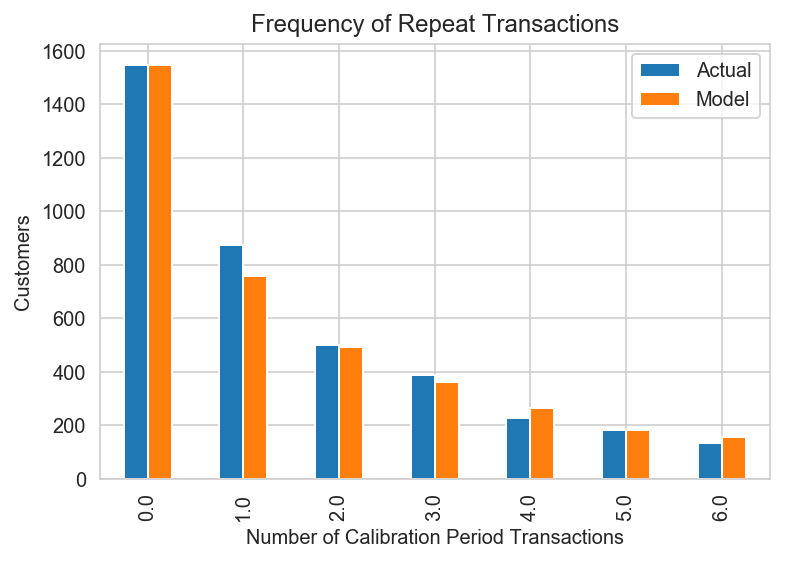

In [102]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)
print('We can see that our actual data and our simulated data line up well. This proves that our model doesnt suck.')

We now partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (just like cross-validation in machine learning practice).

In [106]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-04-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0   80.0                0.0   
12347.0               2.0        121.0  122.0                4.0   
12348.0               2.0        110.0  113.0                1.0   
12350.0               0.0          0.0   65.0                0.0   
12352.0               3.0         34.0   51.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                  245  
12347.0                  245  
12348.0                  245  
12350.0                  245  
12352.0                  245  


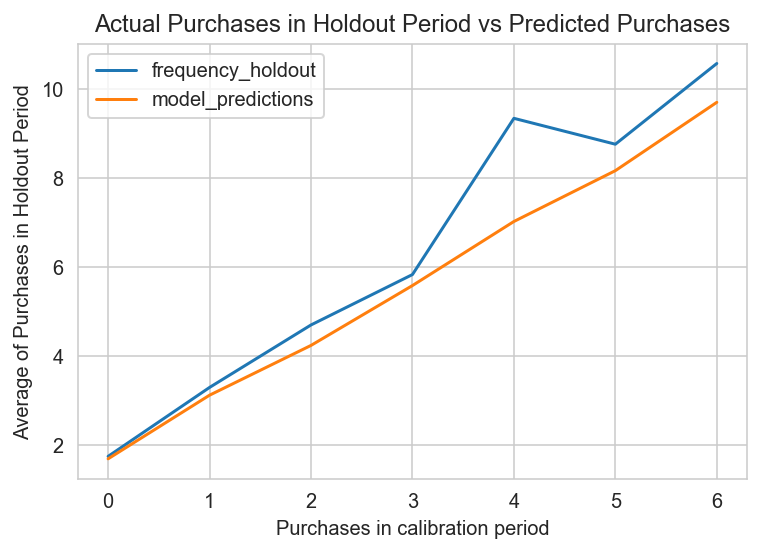

In [107]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

we separate the data into both a in-sample (calibration) and validation (holdout) period

Train= the calibration period consists the beginning to 2011–04–08; 

Test =the validation period spans from 2011–06–09 to 2011–12–09. 

The plot groups all customers in the calibration period by their number of repeat purchases (x-axis) and then averages over their repeat purchases in the holdout period (y-axis). 

The green and blue line presents the model prediction and actual result of the y-axis respectively. As we can see, our model is able to very accurately predict the customer base’s behaviour out of the sampl

## 6 Customer transactions predictions
Most often, the dataset you have at hand will be at the transaction level. Lifetimes has some utility functions to transform that transactional data (one row per purchase) into summary data (a frequency, recency and age dataset).

In [119]:
t = 10
individual = data.loc[12364]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])
print('Our model predicts that customer 12364s future transaction is 0.22 in 10 days')

Our model predicts that customer 12364s future transaction is 0.22 in 10 days


## 7 Customer probability histories
Given a customer transaction history, we can calculate their historical probability of being alive, according to our trained model. For example, we want to look at our best customer’s transactions history and see the probability of being alive:

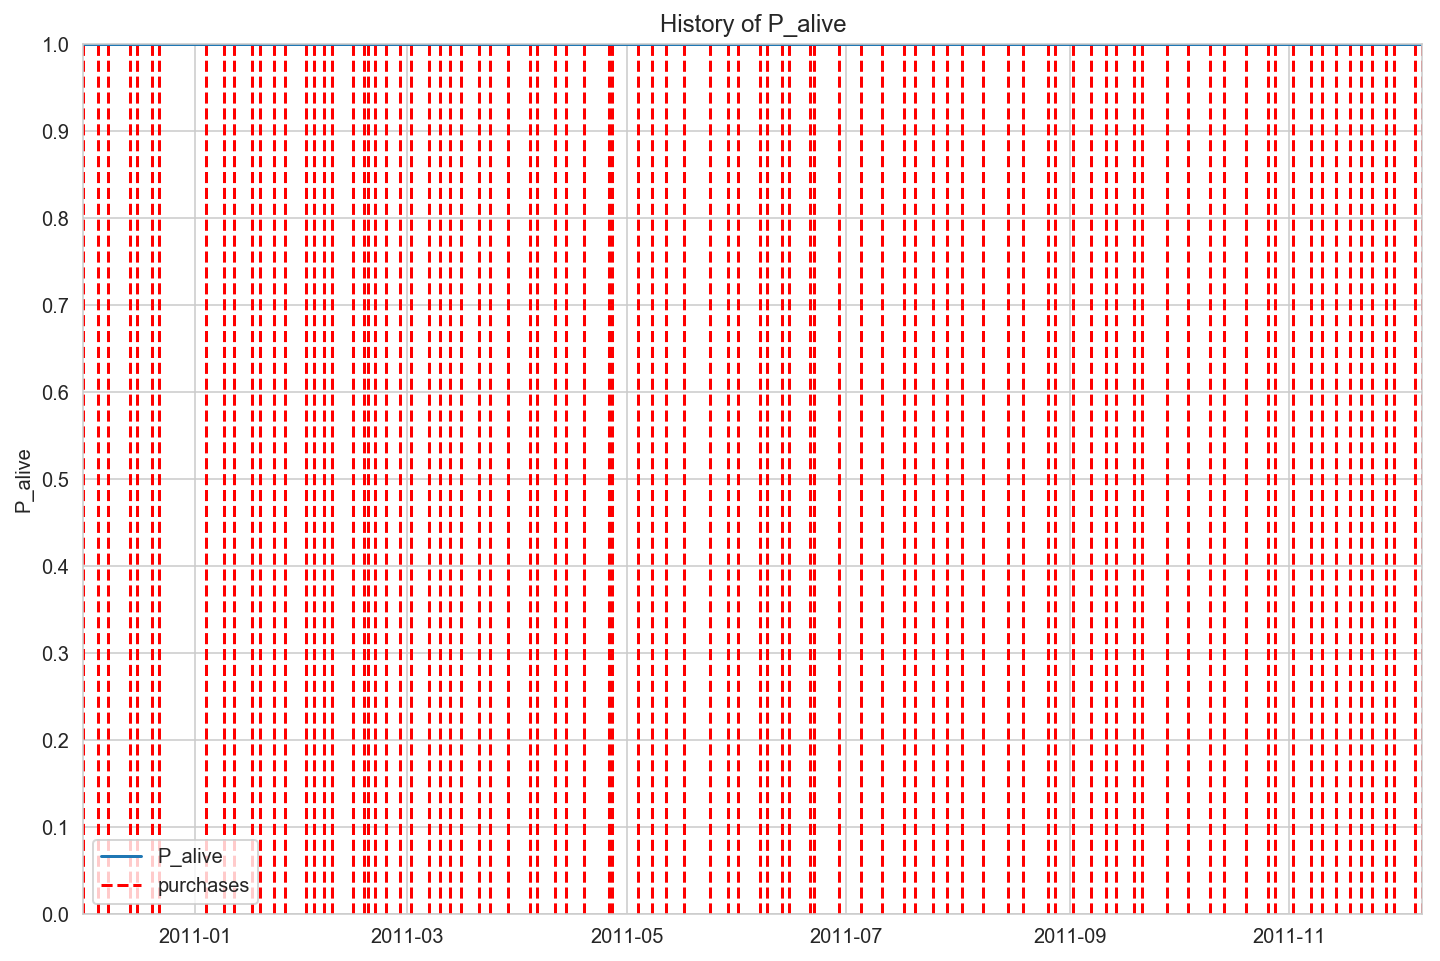

In [124]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

Our best customer is definitely alive, however, he had several hiatus in the second half of the year 2011.

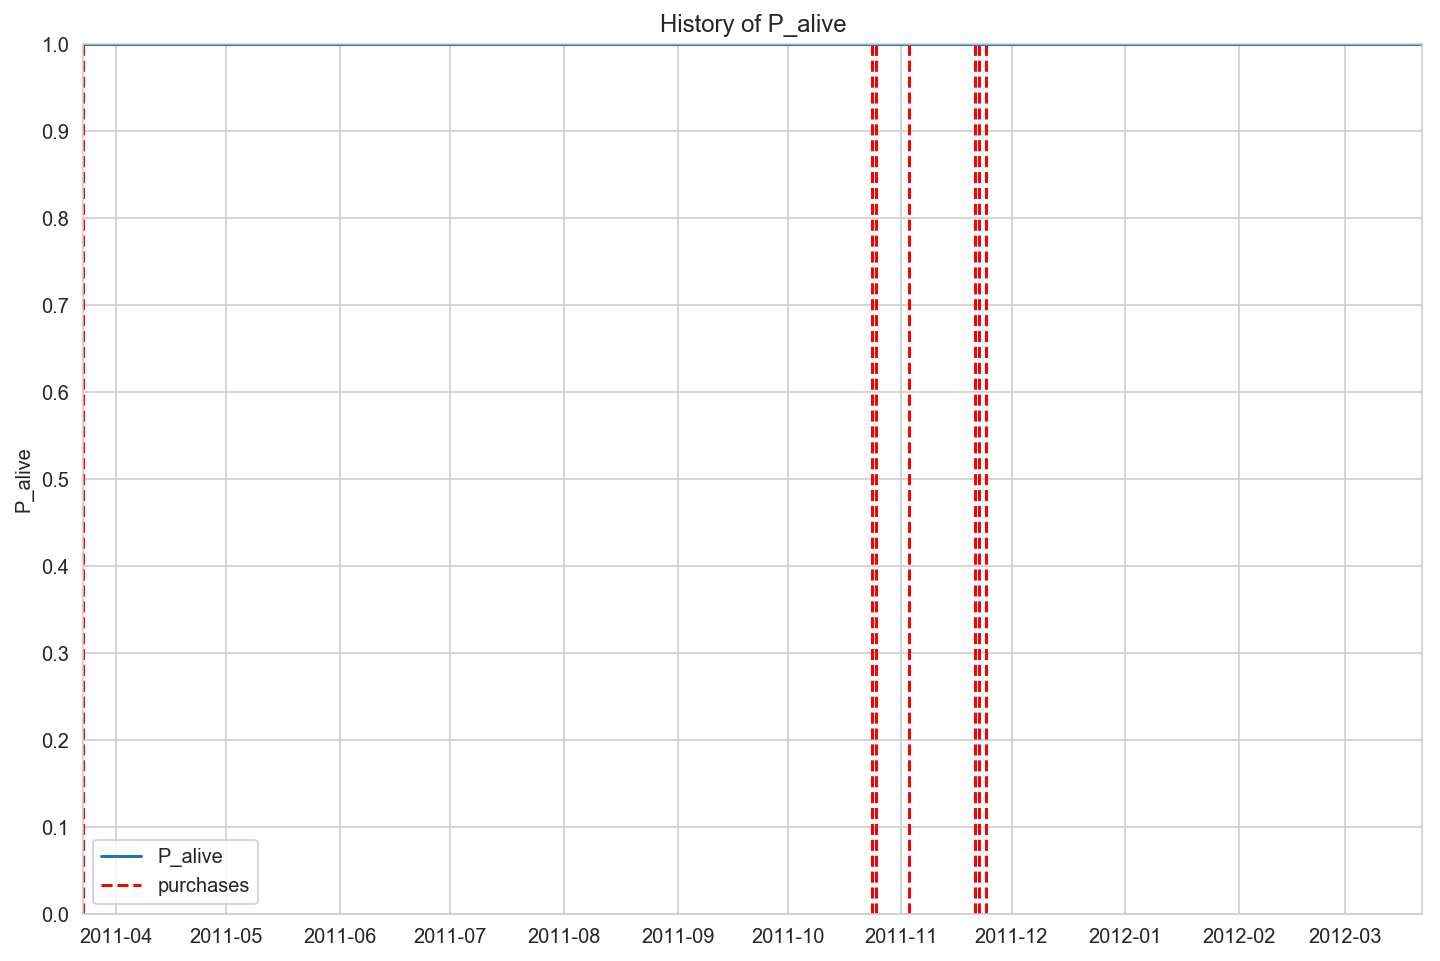

In [127]:
fig = plt.figure(figsize=(12,8))
id = 14607
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

On the other hand, this customer had only purchased once and has dropped off for a some time the customer might or might not dead

## 8 Estimating customer lifetime value using gamma-gamma model of monetary value

For this whole time we didn't take into account the economic value of each transaction and we focused mainly on transactions' occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues).

In [135]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print('We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for',len(returning_customers_summary), 'customers')

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.156569
12348.0           3.0    283.0  358.0      301.480000             0.089572
12352.0           6.0    260.0  296.0      368.256667             0.186994
12356.0           2.0    303.0  325.0      269.905000             0.071721
12358.0           1.0    149.0  150.0      683.200000             0.083385
We are only estimating the customers who had at least one repeat purchase with us. Therefore, we are estimating for 2790 customers


#### The Gamma-Gamma model and the independence assumption

The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [138]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.015882
frequency,0.015882,1.000000


In [136]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [137]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917630
12347.0    569.988809
12348.0    333.762654
12349.0    416.917630
12350.0    416.917630
12352.0    376.166856
12353.0    416.917630
12354.0    416.917630
12355.0    416.917630
12356.0    324.008916
dtype: float64
